# Using ML anonymization to defend against membership inference attacks

In this tutorial we will show how to anonymize models using the ML anonymization module. 

We will demonstrate running inference attacks both on a vanilla model, and then on an anonymized version of the model. We will run a black-box membership inference attack using ART's inference module (https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/art/attacks/inference). 

This will be demonstarted using the Adult dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/nursery). 

For simplicity, we used only the numerical features in the dataset.

## Load data

In [12]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

dataset = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.5, random_state=14)

## Train linear regression model

In [13]:
from sklearn.linear_model import LinearRegression
from art.estimators.regression.scikitlearn import ScikitlearnRegressor

model = LinearRegression()
model.fit(X_train, y_train)

art_classifier = ScikitlearnRegressor(model)

print('Base model accuracy (R2 score): ', model.score(X_test, y_test))

x_train_predictions = np.array([np.argmax(arr) for arr in art_classifier.predict(X_train)]).reshape(-1,1)

Base model accuracy (R2 score):  0.5080618258593723


## Attack
The black-box attack basically trains an additional classifier (called the attack model) to predict the membership status of a sample.
#### Train attack model

In [14]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

# attack_model_type can be nn (neural network), rf (random forest) or gb (gradient boosting)
bb_attack = MembershipInferenceBlackBox(art_classifier, attack_model_type='nn', input_type='loss')

# use half of each dataset for training the attack
attack_train_ratio = 0.5
attack_train_size = int(len(X_train) * attack_train_ratio)
attack_test_size = int(len(X_test) * attack_train_ratio)

# train attack model
bb_attack.fit(X_train[:attack_train_size], y_train[:attack_train_size],
              X_test[:attack_test_size], y_test[:attack_test_size])

# get inferred values for remaining half
inferred_train_bb = bb_attack.infer(X_train[attack_train_size:], y_train[attack_train_size:])
inferred_test_bb = bb_attack.infer(X_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(acc)

0.5180180180180181


This means that for 52% of the data, membership is inferred correctly using this attack.

In [15]:
from diffprivlib.models import LinearRegression as DPLinearRegression
import matplotlib.pyplot as plt

def attack(model, attack_train_ratio=0.5):
    dp_art_classifier = ScikitlearnRegressor(model)
    
    # attack_model_type can be nn (neural network), rf (random forest) or gb (gradient boosting)
    bb_attack = MembershipInferenceBlackBox(dp_art_classifier, attack_model_type='nn', input_type='loss')

    # use half of each dataset for training the attack
    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train) * attack_train_ratio)
    attack_test_size = int(len(X_test) * attack_train_ratio)

    # train attack model
    bb_attack.fit(X_train[:attack_train_size], y_train[:attack_train_size],
                  X_test[:attack_test_size], y_test[:attack_test_size])

    # get inferred values for remaining half
    inferred_train_bb = bb_attack.infer(X_train[attack_train_size:], y_train[attack_train_size:])
    inferred_test_bb = bb_attack.infer(X_test[attack_test_size:], y_test[attack_test_size:])
    # check accuracy
    train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
    test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
    acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
    return acc

regr = DPLinearRegression(bounds_X=(-0.138, 0.2), bounds_y=(25, 346))
regr.fit(X_train, y_train)

print("R2 score for epsilon=%.2f: %.2f" % (regr.epsilon, regr.score(X_test, y_test)))

epsilons = np.logspace(-1, 3, 5)
min_med_max = []
attack_min_med_max = []
runs = 100

for eps in epsilons:
    accuracy = []
    _train_acc = []
    _attack_acc = []
    for _ in range(runs):
        model = DPLinearRegression(epsilon=eps, bounds_X=(-0.138, 0.2), bounds_y=(25, 346))
        model.fit(X_train, y_train)
        accuracy.append(model.score(X_test, y_test))
        _train_acc.append(model.score(X_test, y_test))
        _attack_acc.append(attack(model))
        
    min_med_max.append(list(np.quantile(accuracy, (0.05, 0.5, 0.95))))
    attack_min_med_max.append(np.quantile(_attack_acc, (0.05, 0.5, 0.95)))
    
out = np.array(min_med_max)

out

R2 score for epsilon=1.00: -1712656.16


array([[-7.96275280e+08, -5.37946486e+06, -2.17894102e+05],
       [-4.15389178e+08, -3.10233172e+06, -2.11549578e+05],
       [-6.37736327e+06, -3.99776144e+05, -4.88933884e+01],
       [-3.31897698e+08, -1.12975501e+06, -1.44462912e+04],
       [-8.06570531e+07,  4.02586813e-01,  5.15112258e-01]])

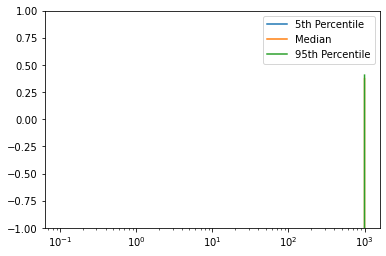

In [12]:
plt.semilogx(epsilons, out[:, 0], label="5th Percentile", zorder=10)
plt.semilogx(epsilons, out[:, 1], label="Median", zorder=10)
plt.semilogx(epsilons, out[:, 2], label="95th Percentile", zorder=10)
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [16]:
attack_min_med_max = np.array(attack_min_med_max)

attack_min_med_max

array([[0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.48175676, 0.5       , 0.51801802]])

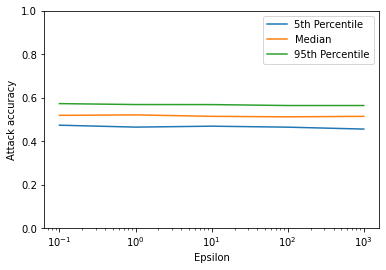

In [9]:
plt.semilogx(epsilons, attack_min_med_max[:, 0], label="5th Percentile")
plt.semilogx(epsilons, attack_min_med_max[:, 1], label="Median")
plt.semilogx(epsilons, attack_min_med_max[:, 2], label="95th Percentile")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("Attack accuracy")
plt.xlabel("Epsilon")
plt.show()

### ML Anonymization - doesn't support rgression yet

In [10]:
from apt.anonymization import Anonymize
k_values=[5, 10, 20, 50, 75]
model_accuracy = []
attack_accuracy = []
unique_values = []

# QI = all
QI = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print('unique rows in original data: ', len(np.unique(X_train, axis=0)))

for k in k_values:
    anonymizer = Anonymize(k, QI)
    anon = anonymizer.anonymize(X_train, x_train_predictions)
    unique_values.append(len(np.unique(anon, axis=0)))
    
    anon_model = LinearRegression()
    anon_model.fit(anon, y_train)

    anon_art_classifier = ScikitlearnRegressor(anon_model)

    model_accuracy.append(anon_model.score(X_test, y_test))
    
    anon_bb_attack = MembershipInferenceBlackBox(anon_art_classifier, attack_model_type='rf', input_type='loss')

    # train attack model
    anon_bb_attack.fit(X_train[:attack_train_size], y_train[:attack_train_size],
                       X_test[:attack_test_size], y_test[:attack_test_size])

    # get inferred values
    anon_inferred_train_bb = anon_bb_attack.infer(X_train[attack_train_size:], y_train[attack_train_size:])
    anon_inferred_test_bb = anon_bb_attack.infer(X_test[attack_test_size:], y_test[attack_test_size:])
    # check accuracy
    anon_train_acc = np.sum(anon_inferred_train_bb) / len(anon_inferred_train_bb)
    anon_test_acc = 1 - (np.sum(anon_inferred_test_bb) / len(anon_inferred_test_bb))
    anon_acc = (anon_train_acc * len(anon_inferred_train_bb) + anon_test_acc * len(anon_inferred_test_bb)) / (len(anon_inferred_train_bb) + len(anon_inferred_test_bb))
    attack_accuracy.append(anon_acc)
    
print('k values: ', k_values)
print('unique rows:', unique_values)
print('model accuracy:', model_accuracy)
print('attack accuracy:', attack_accuracy)

unique rows in original data:  221
k values:  [5, 10, 20, 50, 75]
unique rows: [1, 1, 1, 1, 1]
model accuracy: [-0.0318645415786456, -0.0318645415786456, -0.0318645415786456, -0.0318645415786456, -0.0318645415786456]
attack accuracy: [0.5630630630630631, 0.5720720720720721, 0.5765765765765766, 0.5765765765765766, 0.5675675675675675]
